In [1]:
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# print('Installing dm_control...')
# !pip install -q dm_control>=1.0.18

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

Fri Nov  1 09:48:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:4B:00.0 Off |                  Off |
|  0%   32C    P8             19W /  450W |     434MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70

    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    # fig, ax = plt.subplots(1, 1, figsize=(scaled_width / dpi, scaled_height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

Define Environment

In [6]:
import numpy as np
from dm_control import viewer
from env import mice_env
# from spine import prototype

Main Loop

In [8]:
env = mice_env.rodent_maze_forage()
action_spec = env.action_spec()
time_step = env.reset()

In [14]:
scene = time_step.observation['walker/egocentric_camera']
scene = np.dot(scene[..., :3], [0.2989, 0.5870, 0.1140])

In [16]:
scene.shape

(64, 64)

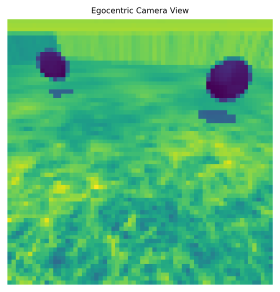

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制图像
plt.imshow(scene)
plt.axis('off')  # 隐藏坐标轴
plt.title('Egocentric Camera View')
plt.show()

In [ ]:
frame_size = {'width': 640, 'height': 480}
pixels = env.physics.render(camera_id=1,**frame_size)
PIL.Image.fromarray(pixels)

In [8]:
def random_policy(time_step):
    # Generates random actions within the specified range
    action = 0.01 * np.random.uniform(action_spec.minimum, action_spec.maximum,
                               size=action_spec.shape)
    # print("reward = {}, discount = {}, observations = {}.".format(
    #   time_step.reward, time_step.discount, time_step.observation))
    return np.clip(action, action_spec.minimum, action_spec.maximum)

In [7]:
def PD_policy(time_step):
    # Access the current positions and velocities
    qpos = env.physics.data.qpos[7:]
    qvel = env.physics.data.qvel[6:]

    # Define desired positions and velocities (for simplicity, assume you want to maintain the current position)
    desired_qpos = np.zeros_like(qpos)
    desired_qvel = np.zeros_like(qvel)

    # Proportional-Derivative control gains
    Kp = 0.1
    Kd = 0.01

    # PD control to compute actuator commands
    position_error = desired_qpos - qpos
    velocity_error = desired_qvel - qvel
    control_signal = 0.01*(Kp * position_error + Kd * velocity_error)

    # Clip the control signal to the action specification limits
    action = np.clip(control_signal, action_spec.minimum, action_spec.maximum)

    return action

In [ ]:
#@title Video of the movement{vertical-output: true}
#@test {"timeout": 600}

duration = 10   # (Seconds)
framerate = 30  # (Hz)
video = []

# Control signal frequency, phase, amplitude.
freq = 5
amp = 0.9

# Initialize a list to store rewards.
rewards = []
discount = []
observation = []

# Simulate, saving video frames and torso locations.
env.physics.reset()
while env.physics.data.time < duration:
  # Inject controls and step the physics.
  action = random_policy(time_step)
  time_step = env.step(action)

  # Store the reward
  rewards.append(time_step.reward)
  discount.append(time_step.discount)
  observation.append(time_step.observation)
  
  # print("reward = {}, discount = {}, observations = {}.".format(
  #     time_step.reward, time_step.discount, time_step.observation))

  # Save video frames.
  if len(video) < env.physics.data.time * framerate:
    pixels = env.physics.render(camera_id=1,**frame_size)
    video.append(pixels.copy())

display_video(video, framerate)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [60]:
# Policy Gradient (PG)

# 策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, obs_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc_mean = nn.Linear(1024, action_size)  # 输出动作的均值
        self.fc_log_std = nn.Linear(1024, action_size)  # 输出动作的对数标准差

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_log_std(x)
        std = torch.exp(log_std)  # 转化为标准差
        return mean, std
        

In [7]:
# Access the current positions and velocities
qpos = env.physics.data.qpos[7:]
qvel = env.physics.data.qvel[6:]

In [61]:
obs_size = len(qpos)+len(qvel)
action_size = len(qpos)

# 初始化策略网络
policy_network = PolicyNetwork(obs_size, action_size)
optimizer = optim.Adam(policy_network.parameters(), lr=1e-3)

# 策略更新
def update_policy(trajectory, gamma=0.99):
    returns = []
    R = 0
    for r in trajectory['rewards'][::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    
    returns = torch.tensor(returns)
    obs = torch.stack(trajectory['observations'])
    
    # print("actions size:", trajectory['actions'])
    actions = torch.stack(trajectory['actions'])
    
    means, stds = policy_network(obs)
    action_distribution = torch.distributions.Normal(means, stds)
    log_probs = action_distribution.log_prob(actions).sum(axis=-1)  # 对每个自由度计算对数概率并相加

    loss = -(log_probs * returns).mean()  # 损失是负的期望回报
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss after each update
    print(f"Policy Update Loss: {loss.item()}")


In [62]:
# 采样数据并更新
trajectory = {'observations': [],'discount':[], 'actions': [], 'rewards': []}
time_step = env.reset()
qpos = time_step.observation['walker/joints_pos']
qvel = time_step.observation['walker/joints_vel']
obs = torch.cat([torch.tensor(qpos, dtype=torch.float32), torch.tensor(qvel, dtype=torch.float32)], dim=0)

In [33]:
frame_size = {'width': 640, 'height': 480}

duration = 20   # (Seconds)
framerate = 30  # (Hz)
video = []

# Control signal frequency, phase, amplitude.
freq = 5
amp = 0.9

while env.physics.data.time < duration:
  # Inject controls and step the physics.
  mean, std = policy_network(obs)  # 使用更新后的策略网络
  std = torch.clamp(std, min=1e-3)  # 设置标准差的最小值为 1e-3
  action_distribution = torch.distributions.Normal(mean, std)
  action = action_distribution.sample()  # 采样生成下一步动作
  action = torch.clamp(action, min=0.01, max=0.99)


  time_step = env.step(action)

  # Store the reward
  trajectory['rewards'].append(time_step.reward)
  trajectory['actions'].append(action)
  trajectory['discount'].append(time_step.discount)
  trajectory['observations'].append(time_step.observation)

  qpos = time_step.observation['walker/joints_pos']
  qvel = time_step.observation['walker/joints_vel']
  obs = torch.cat([torch.tensor(qpos, dtype=torch.float32), torch.tensor(qvel, dtype=torch.float32)], dim=0)
  
   # 检查是否为终止状态
  if time_step.last():
      update_policy(trajectory)  # 更新策略
      trajectory = {'observations': [],'discount':[], 'actions': [], 'rewards': []}
      time_step = env.reset()  # 重置环境
      obs = torch.cat([torch.tensor(qpos, dtype=torch.float32), torch.tensor(qvel, dtype=torch.float32)], dim=0)

  # print("reward = {}, discount = {}, observations = {}.".format(
  #     time_step.reward, time_step.discount, time_step.observation))

  # Save video frames.
  if len(video) < env.physics.data.time * framerate:
    pixels = env.physics.render(camera_id=1,**frame_size)
    video.append(pixels.copy())


In [ ]:
display_video(video, framerate)

In [ ]:
from tqdm import tqdm

max_episodes = 5

# Initialize experience buffer
buffer = {'observations': [], 'actions': [], 'rewards': [], 'next_observations': []}

# Track rewards
episode_rewards = []

# Training loop for multiple episodes
for episode in tqdm(range(max_episodes), desc="Training Episodes"):
    time_step = env.reset()
    qpos = time_step.observation['walker/joints_pos']
    qvel = time_step.observation['walker/joints_vel']
    obs = torch.cat([torch.tensor(qpos, dtype=torch.float32), torch.tensor(qvel, dtype=torch.float32)], dim=0)

    episode_reward = 0  # Reset episode reward
    step = 0
    with tqdm(desc=f"Episode {episode+1}", leave=False) as pbar:
        while not time_step.last():
            # Sample action from policy
            mean, std = policy_network(obs)
            std = torch.clamp(std, min=1e-3)
            action_distribution = torch.distributions.Normal(mean, std)
            action = action_distribution.sample()
            action = torch.clamp(action, min=0.01, max=0.99)

            # Step the environment
            next_time_step = env.step(action)

            # Store in buffer
            buffer['observations'].append(obs)
            buffer['actions'].append(action)
            buffer['rewards'].append(next_time_step.reward)

            # Update the cumulative reward for the episode
            episode_reward += next_time_step.reward

            # Prepare next observation
            qpos_next = next_time_step.observation['walker/joints_pos']
            qvel_next = next_time_step.observation['walker/joints_vel']
            next_obs = torch.cat([torch.tensor(qpos_next, dtype=torch.float32), torch.tensor(qvel_next, dtype=torch.float32)], dim=0)
            buffer['next_observations'].append(next_obs)

            obs = next_obs
            time_step = next_time_step
            step += 1
            pbar.update(1)

     # Store episode reward
    episode_rewards.append(episode_reward)

    # After episode ends, update policy using the buffer
    update_policy(buffer)

    # Reset buffer for next episode
    buffer = {'observations': [], 'actions': [], 'rewards': [], 'next_observations': []}


    # Print episode reward
    print(f"Episode {episode + 1}/{max_episodes}, Reward: {episode_reward}")
    print(f"step_num: {step}")

# After all episodes, print the reward list
print("All Episode Rewards:", episode_rewards)

In [ ]:
print(dir(env))

In [ ]:
env.control_timestep()

# Add Monitor Code!!!!!!!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot episode rewards after training
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()


In [48]:
def evaluate_policy(policy_network, num_episodes=5):
    total_eval_reward = 0
    for eval_episode in range(num_episodes):
        time_step = env.reset()
        qpos = time_step.observation['walker/joints_pos']
        qvel = time_step.observation['walker/joints_vel']
        obs = torch.cat([torch.tensor(qpos, dtype=torch.float32), torch.tensor(qvel, dtype=torch.float32)], dim=0)

        episode_reward = 0
        while not time_step.last():
            with torch.no_grad():  # Don't update the policy during evaluation
                mean, std = policy_network(obs)
                action_distribution = torch.distributions.Normal(mean, std)
                action = action_distribution.sample()
                action = torch.clamp(action, min=0.01, max=0.99)

            # Step the environment
            time_step = env.step(action)
            episode_reward += time_step.reward

            # Prepare next observation
            qpos_next = time_step.observation['walker/joints_pos']
            qvel_next = time_step.observation['walker/joints_vel']
            obs = torch.cat([torch.tensor(qpos_next, dtype=torch.float32), torch.tensor(qvel_next, dtype=torch.float32)], dim=0)

        total_eval_reward += episode_reward
        print(f"Evaluation Episode {eval_episode + 1}/{num_episodes}, Reward: {episode_reward}")

    avg_eval_reward = total_eval_reward / num_episodes
    print(f"Average Evaluation Reward over {num_episodes} episodes: {avg_eval_reward}")


# Actor-Critic Framework

In [ ]:
# Actor-Critic (AC)

# 值网络
class ValueNetwork(nn.Module):
    def __init__(self, obs_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, obs):
        x = torch.relu(self.fc1(obs))
        return self.fc2(x)  # 输出状态的价值

# 初始化值网络
value_network = ValueNetwork(obs_dim)
value_optimizer = optim.Adam(value_network.parameters(), lr=1e-3)

# 更新步骤
def update_actor_critic(trajectory, gamma=0.99):
    returns = []
    R = 0
    for r in trajectory['rewards'][::-1]:
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    obs = torch.stack(trajectory['observations'])
    actions = torch.tensor(trajectory['actions'])
    
    values = value_network(obs).squeeze()
    advantages = returns - values  # 计算优势函数
    
    # 更新 Actor
    log_probs = torch.log(policy_network(obs).gather(1, actions.unsqueeze(1)))
    policy_loss = -(log_probs * advantages.detach()).mean()
    
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    
    # 更新 Critic
    value_loss = nn.functional.mse_loss(values, returns)
    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
